Index(['datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'windspeedmean', 'sealevelpressure', 'cloudcover', 'BarajDoluluk',
       'dakika'],
      dtype='object')
Epoch 1/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 2/50, Train Loss: 0.0003, Test Loss: 0.0001
Epoch 3/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 4/50, Train Loss: 0.0003, Test Loss: 0.0001
Epoch 5/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 6/50, Train Loss: 0.0003, Test Loss: 0.0001
Epoch 7/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 8/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 9/50, Train Loss: 0.0003, Test Loss: 0.0001
Epoch 10/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 11/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 12/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 13/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 14/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 15/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 16/50, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 17/5

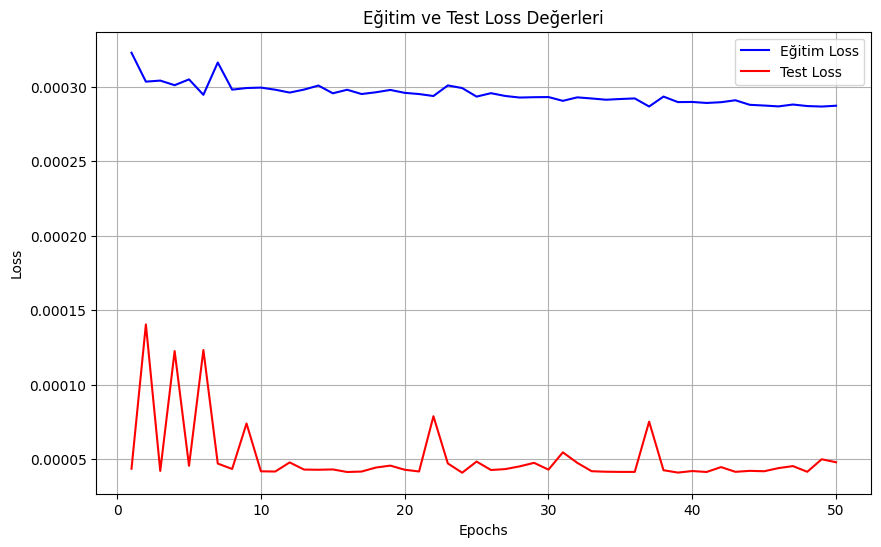

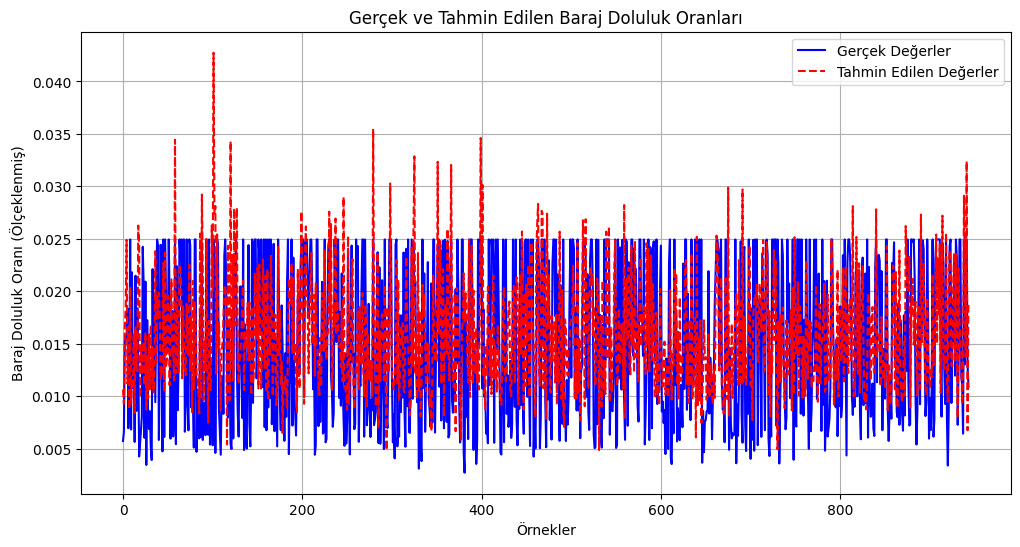

In [8]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Excel verilerini yükleme
data = pd.read_excel('ıstırancalarkullan.xlsx')
print(data.columns)
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features =['temp', 'feelslike', 'dew', 'humidity', 'precip',
       'windspeedmean', 'sealevelpressure', 'cloudcover',
       'dakika']
target = 'BarajDoluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Eğitim ve test loss değerlerini saklamak için listeler
train_losses = []
test_losses = []

# Model eğitimi
epochs = 50
training_start_time = time.time()  # Eğitim zamanını ölçmek için başlangıç zamanı
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Test seti üzerinde loss hesaplama
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch.view(-1, 1))
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
training_end_time = time.time()  # Eğitim zamanını ölçmek için bitiş zamanı

# Eğitim süresi
training_time = training_end_time - training_start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

# Test zamanı (çıkarım zamanı) ölçme
inference_start_time = time.time()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())
inference_end_time = time.time()

inference_time = inference_end_time - inference_start_time
print(f"Çıkarım süresi: {inference_time:.2f} saniye")

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Epoch başına loss grafiği
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Eğitim Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Eğitim ve Test Loss Değerleri')
plt.legend()
plt.grid(True)
plt.show()

# Gerçek ve tahmin edilen değerler grafiği
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()
